# Feature analysis



In [69]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [70]:
df = pd.read_csv('../final_merge.csv')

Let's put the dataframe in a good form for the rest of the analysis.

First, we remove all useless column, or the one we don't want to describe a song.

In [71]:
df.columns

Index(['Unnamed: 0', 'song_hotttnesss', 'song_id', 'artist_latitude',
       'artist_location', 'artist_longitude', 'track_id', 'loudness_x',
       'mode_x', 'tempo_x', 'key_x', 'genre1_cd2c', 'genre2_cd2c',
       'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1', 'artist_id',
       'duration', 'artist_hotttnesss', 'year', 'danceability', 'energy',
       'key_y', 'loudness_y', 'mode_y', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo_y', 'duration_ms',
       'track_popularity', 'album_release'],
      dtype='object')

In [72]:
df_stage1 = df.drop(['Unnamed: 0', 'artist_latitude', 'artist_location', 'artist_id', 'artist_longitude', 'song_id', 'track_id', 'artist_hotttnesss', 'mode_x', 'mode_y'], axis=1)

We will need a one hot encoded matrix for genre for future analysis. We need all the genres in a first time.

In [73]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df_stage1[col_name].unique())
print(genres)
print(len(genres))

{nan, nan, 'Rap', 'Pop_Rock', 'International', 'World', 'Blues', 'Country', 'Electronic', 'Pop', 'New Age', 'Reggae', 'Rock', 'Folk', 'RnB', 'Vocal', 'Jazz', 'Punk', 'Latin', 'Metal'}
20


We have 17 different genres (nan are unkownn and international is the same as world). To do a meaningful analysis of the genre analysis over the year a minimum amount of songs of the analyzed type must be in the dataset. In the following cells we first replace the nan and replace International by World. 

In [74]:
df_stage1[genres_cols] = df_stage1[genres_cols].fillna('Unknown')
df_stage1[genres_cols] = df_stage1[genres_cols].replace('International', 'World')

Let's just check that we have the wanting form

In [75]:
df_stage1[genres_cols].head()

,genre1_cd2c,genre2_cd2c,genre1_cd2,genre2_cd2,genre1_cd1,genre2_cd1
0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
1,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
2,Unknown,Unknown,Electronic,Rap,Electronic,Rap
3,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
4,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


For the moment we have 6 columns for the genres, we would like to see if we can summarize these columns in one or two columns.
First we perform a pivot and count the number of different values there are in each column. 

In [76]:
genres = set([])
genres_cols = ['genre1_cd2c', 'genre2_cd2c', 'genre1_cd2', 'genre2_cd2', 'genre1_cd1', 'genre2_cd1']
for col_name in genres_cols:
    genres = genres | set(df_stage1[col_name].unique())
    df_stage1[col_name] = df_stage1[col_name].astype(str)
print(genres)
print(len(genres))

{'Rap', 'Pop_Rock', 'World', 'Blues', 'Country', 'Electronic', 'Pop', 'New Age', 'Reggae', 'Rock', 'Unknown', 'Folk', 'RnB', 'Vocal', 'Jazz', 'Punk', 'Latin', 'Metal'}
18


In [77]:
for genre in list(genres):
    df_stage1[genre] = 0
    for col_name in genres_cols:
        df_stage1.loc[df_stage1[col_name] == genre, genre] = 1
df_stage1.drop(columns=['Unknown'], axis=1, inplace=True)
genres.remove('Unknown')

It could be useful to see if a song as multiple genres.

In [78]:
df_stage1['nb_genre'] = np.sum(df_stage1.iloc[:, -17:].values, axis=1)
df_stage2 = df_stage1.drop(columns=genres_cols).copy()

Let's make sure we have a hot encoded matrix at the end now

In [79]:
df_stage2.head()

,song_hotttnesss,loudness_x,tempo_x,key_x,duration,year,danceability,energy,key_y,loudness_y,...,Reggae,Rock,Folk,RnB,Vocal,Jazz,Punk,Latin,Metal,nb_genre
0,0.542899,-4.829,87.002,10,252.05506,2003,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,0.299877,-10.555,150.778,9,156.55138,1995,0.489,0.583,9.0,-10.303,...,0,0,0,0,0,0,0,0,0,0
2,0.617871,-2.060,177.768,7,138.97098,2006,0.662,0.823,4.0,-1.711,...,0,0,0,0,0,0,0,0,0,2
3,NaN,-4.654,87.433,7,145.05751,2003,0.690,0.619,7.0,-4.302,...,0,0,0,0,0,0,0,0,0,0
4,NaN,-7.806,140.035,5,514.29832,0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


Now that the matrix is ready, let's see if we can spot something from a simple correlation between the data, especially between song_hotttnesss and the rest of the features.

In [85]:
def plot_corr(df):
    '''
        Plot the correlation matrix of a dataframe
        The plot will be triangular with negative values blue and positive values red
        Code taken from https://seaborn.pydata.org/examples/many_pairwise_correlations.html
        :param df: The dataframe
        :type df: DataFrame
    '''
    sns.set(style="white")

    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(16, 12))
    f.suptitle("Correlation heatmap")

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    sns_plot.savefig("correlation_df_MSD_Spotify.png")


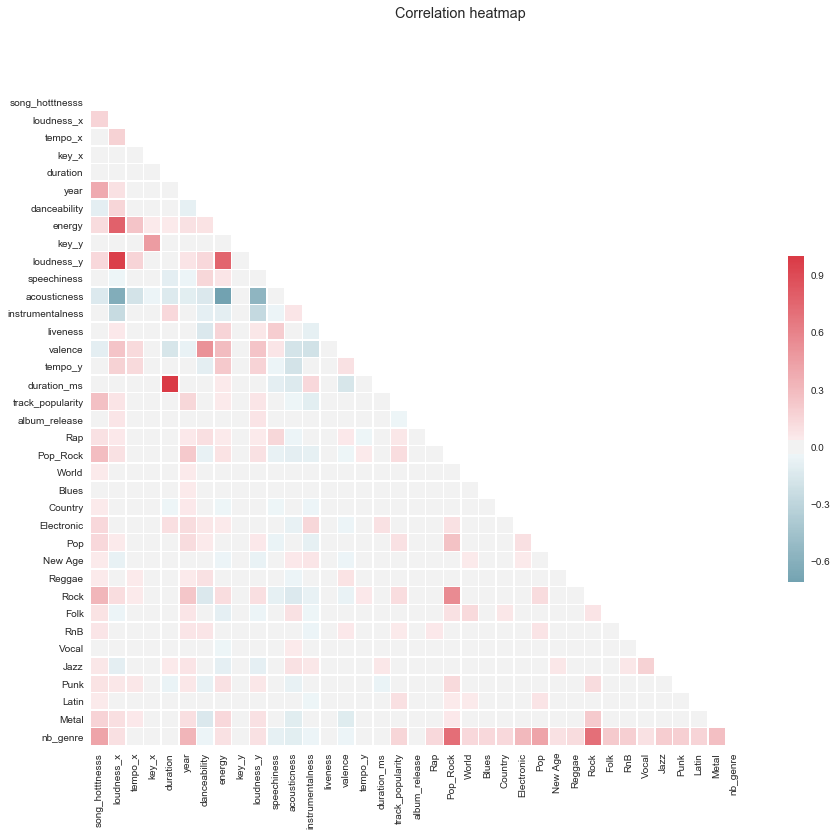

In [81]:
plot_corr(df_stage2)

What do we see here ?

1) the value between spotify and MSD on the duration is highly correlated 

2) track_popularity and song_hotttnesss is moderately correlated, thus we will keep the song_hotttnesss

3) year of MSD and album release from spotify is absolutely not correlated, so let's keep the one from MSD again

Let's drop the useless column again

In [82]:
df_stage3 = df_stage2.drop(['album_release', 'track_popularity', 'duration_ms'], axis=1)

We want know to check if we can train a regressor and export the features importance. Here we use an RandomForest like in HW4, but a regressor one this time.

In [84]:
regressor = RandomForestRegressor(n_jobs=-1, n_estimators = 400, verbose=True)

df_stage4 = df_stage3.copy().dropna(subset=['song_hotttnesss'])

train_set = df_stage4.drop(['song_hotttnesss', 'nb_genre'], axis=1)
train_set = train_set.fillna(-1)

train_label = df_stage4.song_hotttnesss

regressor.fit(train_set, train_label)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 19.8min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
           oob_score=False, random_state=None, verbose=True,
           warm_start=False)

In [87]:
sum = 0.0
for a, b in sorted(zip(regressor.feature_importances_, train_set.columns), reverse=True):
    print(a, " : ", b)
    if b in genres:
        sum += a
        
sum

0.216703051962  :  nb_genre
0.140148488465  :  loudness_x
0.134467627843  :  duration
0.130034570277  :  tempo_x
0.106506480566  :  year
0.0535590166285  :  key_x
0.0234802122867  :  valence
0.0234604374979  :  acousticness
0.0216052020706  :  danceability
0.0213278687871  :  liveness
0.0208942498928  :  speechiness
0.0201545708853  :  loudness_y
0.0198783514311  :  tempo_y
0.0195674181802  :  energy
0.0172643521918  :  instrumentalness
0.0101237719954  :  key_y
0.00222541369573  :  Metal
0.00219717351222  :  Rock
0.00195120457532  :  Pop_Rock
0.00189214148049  :  Pop
0.00164735037815  :  Electronic
0.00141054751699  :  Blues
0.00137198228871  :  RnB
0.00125422828126  :  Country
0.00110381650692  :  Jazz
0.00103309050316  :  Rap
0.0010074221376  :  Reggae
0.000957113707679  :  Folk
0.000937055306605  :  Latin
0.000646835628933  :  World
0.000510261227387  :  Punk
0.00044029852825  :  New Age
0.000238393764301  :  Vocal


0.020824329039705252

In [90]:
pd.DataFrame([train_set.columns,regressor.feature_importances_]).hist()

ValueError: num must be 1 <= num <= 0, not 1